In [2]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from os import listdir
import string
from sklearn.metrics import mean_squared_error

csv_path = "F:\Business Intelligence\project\project2\Project 2 QuantFund resource\Project 2 QuantFund\Data\\"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '5DForward.csv')) #stock
# In the simulation,
# you should also calculate indices returns,
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_5DForward.csv')) #mkt


factor_folder = "F:\Business Intelligence\project\project2\Project 2 QuantFund resource\Project 2 QuantFund\Data\ALL_factors\\" # I am only using several sample factors here. You should try all factors
# factor_folder = "Data/ALL_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)
print(factor_list)
# Read all factor files
# Remeber to Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean() )/ df.std()
    i = i + 1
print()
print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

Clean Data

In [3]:
# clean return data
rt = stockforwardreturn.iloc[242:2799,:]
a = dfs[0].columns.tolist()
b = rt.columns.tolist()
more = list(set(b) - set(a))
rt = rt.drop(more,axis=1)
print(rt.shape)
print(dfs[0].shape)
for i in range(len(dfs)):
    dfs[i] = dfs[i].reset_index()
    dfs[i] = pd.melt(frame=dfs[i],id_vars='date',value_vars=dfs[i].columns.tolist()[1:],var_name='stock',value_name=factor_list[i].rstrip('.csv'))
melted = pd.DataFrame()
melted = pd.concat([melted,dfs[0]],axis=1)
for i in range(1,len(dfs)):
    melted = pd.merge(left=melted,right=dfs[i],on=['date','stock'])
rt = rt.reset_index()
rt = pd.melt(frame=rt ,id_vars='date', value_vars=rt.columns.tolist()[1:],var_name='stock',value_name='return')
melted = pd.merge(left=melted,right=rt,on=['date','stock'])
print(melted.head())
print(melted.shape)
na = melted.dropna()


print(na.shape)
from sklearn.model_selection import train_test_split
X=na.filter(['AD','DAVOL20','EMA26','RealizedVolatility','TVMA6','VEMA10'])
y=na.filter(['return'])
y=(y-y.mean())/y.std()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=233)
#print(X_train.head())
#print(y_train.head())

(2557, 3569)
(2557, 3569)
        date      stock  NonCurrentAssetsRatio  NonOperatingNPTTM   REVS750  \
0 2008-01-02  000001.SZ                    NaN          -0.135527  2.888453   
1 2008-01-03  000001.SZ                    NaN          -0.135527  2.797419   
2 2008-01-04  000001.SZ                    NaN          -0.135527  2.944403   
3 2008-01-07  000001.SZ                    NaN          -0.135527  3.059996   
4 2008-01-08  000001.SZ                    NaN          -0.135527  3.235416   

      TVMA6   DAVOL20  GainLossVarianceRatio60  InterestCover    PEIndu  ...  \
0 -0.001905 -0.158321                 0.856878            NaN -0.366891  ...   
1  0.022230 -0.206822                 0.869264            NaN -0.372034  ...   
2  0.032540 -0.255323                 0.610174            NaN -0.364962  ...   
3  0.149184 -0.134070                 0.616198            NaN -0.356511  ...   
4  0.268527  0.059935                 0.521690            NaN -0.339611  ...   

   PEHist120     E

Random Forest

In [4]:
from sklearn import datasets,ensemble
import matplotlib.pyplot as plt
X_train=np.array(X_train)
X_train=X_train
print(X_train)
X_test=np.array(X_test)
X_test=X_train
print(X_test)
y_train=np.array(y_train)
y_train=y_train
y_test=np.array(y_test)
y_test=y_test
y_train=y_train.ravel()
y_test=y_test.ravel()
print(y_train)
print(y_test)
def test_RandomForestRegressor(*data):
    X_train,X_test,y_train,y_test=data
    regr=ensemble.RandomForestRegressor()
    regr.fit(X_train,y_train)
    ridge_score2 = mean_squared_error(y_test, regr.predict(X_test))
    return ridge_score2
#
#test_RandomForestRegressor(X_train,X_test,y_train,y_test)

#Save the predicted result
regr=ensemble.RandomForestRegressor()
regr.fit(X_train,y_train)
ridge_score=mean_squared_error(y,regr.predict(X))
print('This is MSE')
print(ridge_score)
result=regr.predict(X)
result=pd.DataFrame(result)
print(result)

[[-1.17819939e+00 -6.62310306e-01 -3.04437174e-01 -7.48071344e-01
  -6.54218137e-02  1.79405788e-01]
 [-5.54252892e-01  1.37941921e+00  1.05417440e+00 -1.53821210e-02
   1.15240253e+00  7.07506293e-01]
 [ 3.75281390e-01 -2.14661329e-02  6.44410782e-01 -4.56302207e-02
   5.71897526e-01  5.61659910e-01]
 ...
 [-1.08247149e-01 -1.84753061e+00 -1.20597788e-03 -2.36195046e-01
  -4.87439927e-01 -4.41916134e-01]
 [-4.81421403e-01  3.43439918e-01 -5.43894994e-01 -7.85924694e-01
  -5.22167394e-01 -5.20519119e-01]
 [-3.41651205e-01 -2.04388065e+00  1.49510035e+00 -3.66942853e-01
  -1.94446485e-01 -5.68723848e-01]]
[[-1.17819939e+00 -6.62310306e-01 -3.04437174e-01 -7.48071344e-01
  -6.54218137e-02  1.79405788e-01]
 [-5.54252892e-01  1.37941921e+00  1.05417440e+00 -1.53821210e-02
   1.15240253e+00  7.07506293e-01]
 [ 3.75281390e-01 -2.14661329e-02  6.44410782e-01 -4.56302207e-02
   5.71897526e-01  5.61659910e-01]
 ...
 [-1.08247149e-01 -1.84753061e+00 -1.20597788e-03 -2.36195046e-01
  -4.87439927e

Save the result

In [ ]:
#save_result_path =r"F:\Business Intelligence\project\project2\Project 2 QuantFund resource\Project 2 QuantFund\Data\New_factors\\"
#result.to_csv(os.path.join(save_result_path, 'result.csv'))
na=na.filter(['date','stock'])
melted=melted.filter(['date','stock'])
na.insert(loc=0,column='predictedy',value=result.values)
for_bt=pd.merge(melted,na,how='left',on=['date','stock'])
for_bt=for_bt[['date','stock','predictedy']]
#Transform to standard format
td_bt=pd.Series(list(for_bt['predictedy']),index=[for_bt['date'],for_bt['stock']])
td_bt=td_bt.unstack()
save_result_path =r"F:\Business Intelligence\project\project2\Project 2 QuantFund resource\Project 2 QuantFund\Data\New_factors\\"
print(td_bt.shape)
td_bt.to_csv(os.path.join(save_result_path, 'RF.csv'))

Cross Validation

In [ ]:

#Cross Validation(Due to the large size of data, please use a server to run this code)
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)
kfold_baseset=na.filter(['AD','DAVOL20','EMA26','RealizedVolatility','TVMA6','VEMA10','return'])
kfold_baseset=np.array(kfold_baseset)
X=np.array(X)
y=np.array(y)
TMSE=0
for train_idex, test_index in kf.split(kfold_baseset):
    X_train,y_train=X[train_idex],y[train_idex]
    X_test,y_test=X[test_index],y[test_index]
    y_train=y_train.ravel()
    y_test=y_test.ravel()
    MSE=test_RandomForestRegressor(X_train,X_test,y_train,y_test)
    TMSE += MSE
print(TMSE/10)


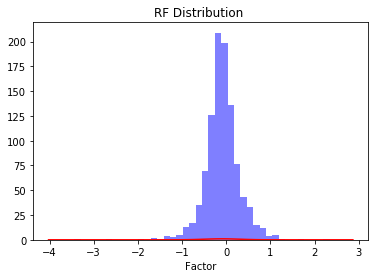

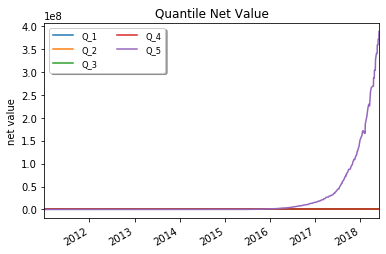

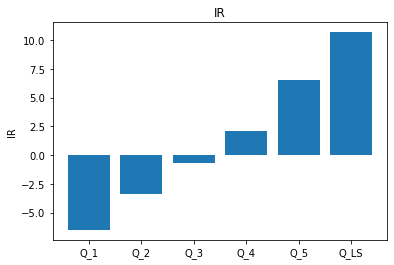

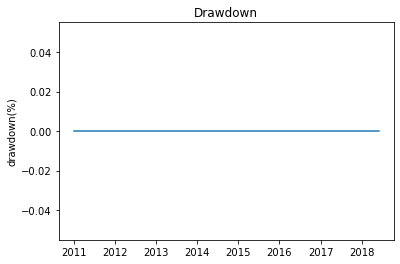

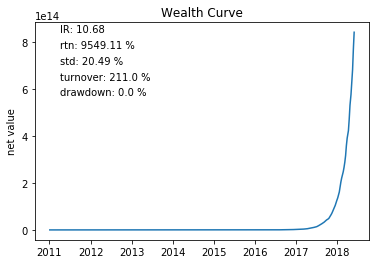

In [5]:
#%run -i 'helper.py'

#%run -i 'backtestlite.py'
import backtestlite as bt
import helper
#set the working directory and some initial parameters. 

working_directory = 'Data/'
#Directory to import the factor you built
factor_path_all = 'Data/ALL_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor = "RF"

Type = "LS" # this stand for long-short strategy. 


def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = bt.Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = helper.DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)